# **Preparación**


#### Importaciones
En esta primera celda importamos todas las librerías necesarias para el notebook. `numpy` para las matemáticas avanzadas, `pandas` para manipulación de datos, `geopandas` para datos geográficos, y `matplotlib` para visualización.


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


#### Carga de Datos
Cargamos los conjuntos de datos para el Holoceno y el Último Máximo Glacial (LGM) desde los archivos CSV correspondientes. Estos datos contienen las coordenadas geográficas y los valores de deposición de polvo que usaremos para nuestras estimaciones de vecinos más cercanos.


In [2]:
import pandas as pd


# Cargar datos para el Holoceno
dataframe_empirical_Holocene = pd.read_csv('df_empirical_Holocene.csv')

# Cargar datos para el Último Máximo Glacial (LGM)
dataframe_empirical_LGM = pd.read_csv('df_empirical_LGM.csv')

# Verificamos las primeras filas del DataFrame del Holoceno para asegurarnos de que se cargó correctamente
dataframe_empirical_Holocene.head()





,lon,lat,dep,log_dep,log_dep_norm
0,1.37,78.87,3.999995,0.602059,0.185196
1,-61.00,77.00,0.040000,-1.397941,-1.669137
2,-42.32,75.10,0.008000,-2.096911,-2.317199
3,-6.72,74.58,3.100001,0.491362,0.082561
4,-37.63,72.58,0.009000,-2.045758,-2.269772


In [3]:
# Verificamos las primeras filas del DataFrame del LGM
dataframe_empirical_LGM.head()

,lon,lat,dep,log_dep,log_dep_norm
0,-61.00,77.00,0.080000,-1.096911,-2.662962
1,-42.32,75.10,0.170000,-0.769551,-2.317613
2,-37.63,72.58,0.326000,-0.486782,-2.019304
3,129.42,71.77,81.999907,1.913813,0.513214
4,-27.00,71.00,0.120000,-0.920818,-2.477192


# **Inciso 2**

#### Función para calcular la distancia euclidiana
Se ocupará como complemento y comparación (redefinida del notebook de ejemplo)

In [4]:
def calcular_distancia_euclidiana(punto1, punto2):
   
    latitud1, longitud1 = punto1
    latitud2, longitud2 = punto2
    # Convertir latitud y longitud a radianes
    latitud1, longitud1, latitud2, longitud2 = map(np.radians, [latitud1, longitud1, latitud2, longitud2])
    # Calcular la distancia euclidiana
    distancia_longitud = longitud2 - longitud1
    distancia_latitud = latitud2 - latitud1
    distancia_total = np.sqrt(distancia_latitud**2 + distancia_longitud**2)

    return distancia_total


# **Inciso 3**

#### Función para calcular la distancia geodésica
En esta sección definimos la función `calcular_distancia_geodesica`. Esta función determina la distancia entre dos puntos en la superficie de la Tierra, considerando la forma esférica del planeta. Se toman como parámetros las coordenadas geográficas en grados (latitud y longitud) y se devuelve la distancia en kilómetros.


In [5]:
def calcular_distancia_geodesica(punto1, punto2, radio=6371.0):
    # Convertir latitud y longitud de grados a radianes
    latitud1, longitud1 = np.radians(punto1)
    latitud2, longitud2 = np.radians(punto2)

    # Aplicar fórmula de distancia geodésica
    distancia = radio * np.arccos(
        np.sin(latitud1) * np.sin(latitud2) + 
        np.cos(latitud1) * np.cos(latitud2) * 
        np.cos(longitud2 - longitud1)
    )

    return distancia


#### Implementación y aplicación del método de k-Vecinos más cercanos
En esta sección, implementamos y aplicamos el método de k-vecinos más cercanos para estimar la deposición de polvo normalizada en nuestras muestras de datos del Holoceno y del Último Máximo Glacial (LGM) utilizando las dos métricas de distancia (geodésica y euclidiana). 

In [6]:
def estimacion_vecinos_cercanos(dataframe, punto, k, tipo_distancia):

    if tipo_distancia == "geodesica":
        funcion_distancia = calcular_distancia_geodesica
    else:
        funcion_distancia = calcular_distancia_euclidiana
    
    # Calcular distancias a todos los puntos
    distancias = dataframe.apply(lambda fila: funcion_distancia(punto, (fila['lat'], fila['lon'])), axis=1)
    vecinos_cercanos = distancias.nsmallest(k)
    return dataframe.loc[vecinos_cercanos.index, 'log_dep_norm'].mean()




Calculamos las estimaciones para cada punto en nuestros conjuntos de datos y almacenamos los resultados para su análisis y visualización posterior. 

In [7]:
k = 5  # Ejemplo de vecinos

# Calcular estimaciones para Holoceno
dataframe_empirical_Holocene['est_geodesica'] = dataframe_empirical_Holocene.apply(
    lambda row: estimacion_vecinos_cercanos(dataframe_empirical_Holocene, (row['lat'], row['lon']), k, 'geodesica'), axis=1)

dataframe_empirical_Holocene['est_euclidiana'] = dataframe_empirical_Holocene.apply(
    lambda row: estimacion_vecinos_cercanos(dataframe_empirical_Holocene, (row['lat'], row['lon']), k, 'euclidiana'), axis=1)



# Repetir para datos del LGM
dataframe_empirical_LGM['est_geodesica'] = dataframe_empirical_LGM.apply(
    lambda row: estimacion_vecinos_cercanos(dataframe_empirical_LGM, (row['lat'], row['lon']), k, 'geodesica'), axis=1)

dataframe_empirical_LGM['est_euclidiana'] = dataframe_empirical_LGM.apply(
    lambda row: estimacion_vecinos_cercanos(dataframe_empirical_LGM, (row['lat'], row['lon']), k, 'euclidiana'), axis=1)



C:\Users\José Luis\AppData\Local\Temp\ipykernel_15384\2184790061.py:7: RuntimeWarning: invalid value encountered in arccos
  distancia = radio * np.arccos(
C:\Users\José Luis\AppData\Local\Temp\ipykernel_15384\2184790061.py:7: RuntimeWarning: invalid value encountered in arccos
  distancia = radio * np.arccos(


# **Inciso 4**

#### Visualización de las estimaciones de deposición de polvo utilizando la distancia geodésica
Esta visualización muestra las estimaciones de deposición de polvo para el Holoceno y el Último Máximo Glacial (LGM) calculadas con la distancia geodésica. Los mapas de calor representan la intensidad de la deposición de polvo normalizada, proporcionando una visualización directa del impacto de utilizar una métrica que tiene en cuenta la curvatura de la Tierra.


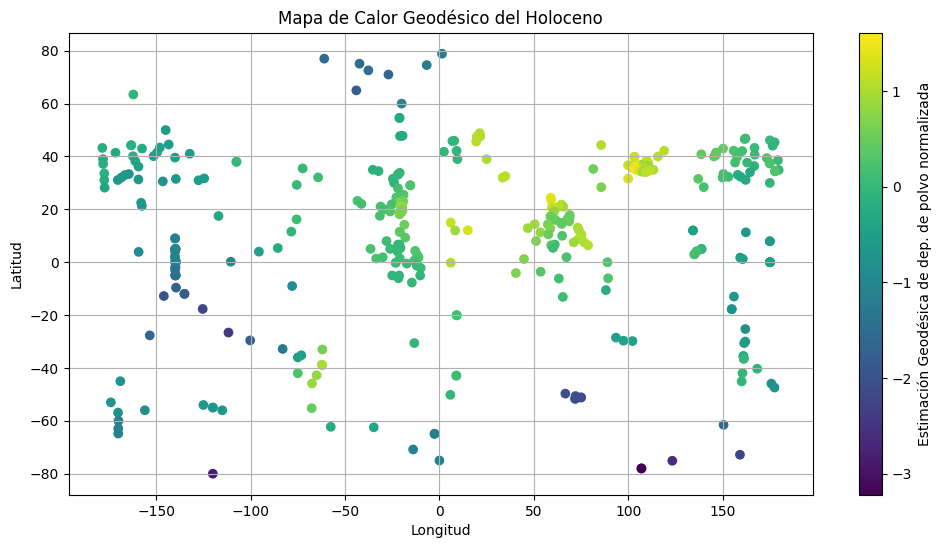

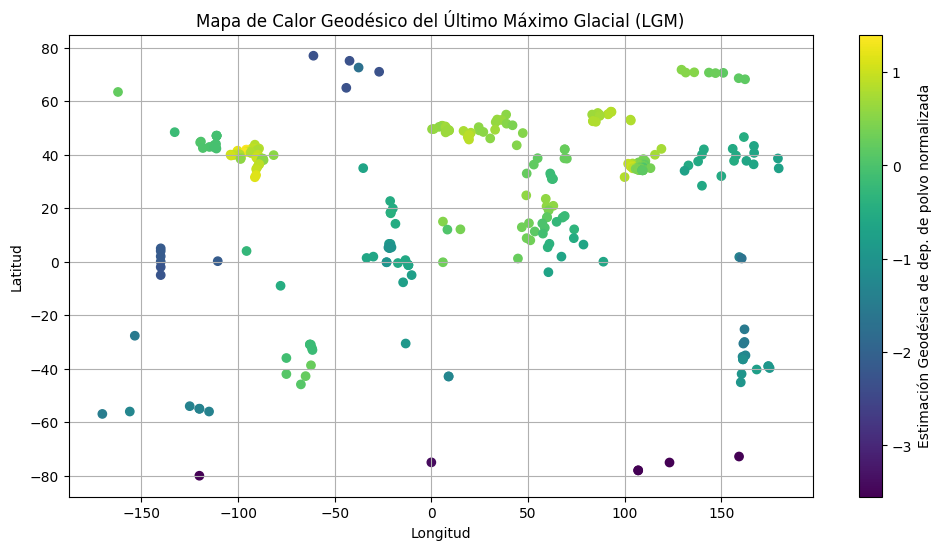

In [8]:
# Visualización para el Holoceno utilizando la distancia geodésica
plt.figure(figsize=(12, 6))
plt.scatter(dataframe_empirical_Holocene['lon'], dataframe_empirical_Holocene['lat'],
            c=dataframe_empirical_Holocene['est_geodesica'], cmap='viridis', marker='o')
plt.colorbar(label='Estimación Geodésica de dep. de polvo normalizada')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Mapa de Calor Geodésico del Holoceno')
plt.grid(True)
plt.show()

# Visualización para el LGM utilizando la distancia geodésica
plt.figure(figsize=(12, 6))
plt.scatter(dataframe_empirical_LGM['lon'], dataframe_empirical_LGM['lat'],
            c=dataframe_empirical_LGM['est_geodesica'], cmap='viridis', marker='o')
plt.colorbar(label='Estimación Geodésica de dep. de polvo normalizada')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Mapa de Calor Geodésico del Último Máximo Glacial (LGM)')
plt.grid(True)
plt.show()

# **Inciso 5**

#### Cálculo y visualización de la diferencia entre distancias geodésica y euclidiana
Calculamos la diferencia absoluta entre las estimaciones de deposición de polvo basadas en la distancia geodésica y la euclidiana. Luego, visualizamos esta diferencia para entender cómo la elección de la métrica de distancia afecta las estimaciones en diferentes ubicaciones geográficas.


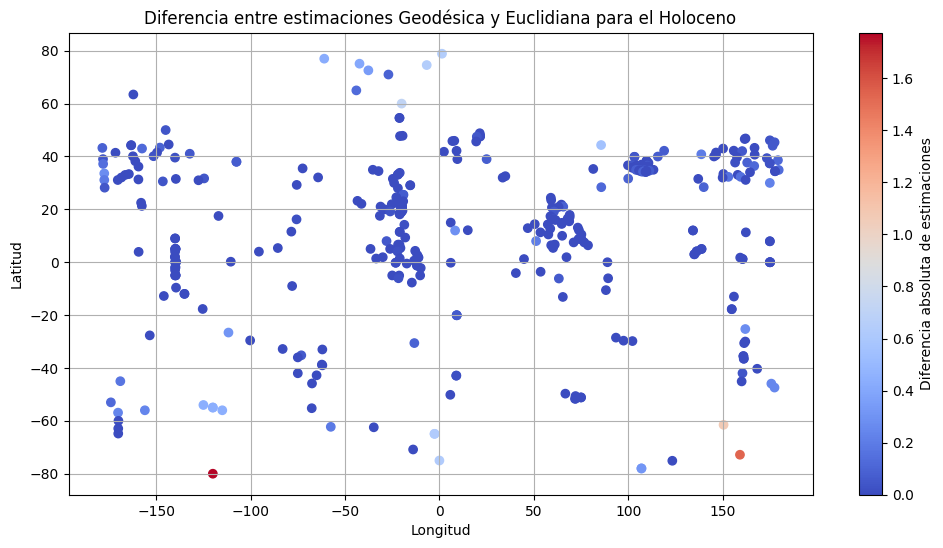

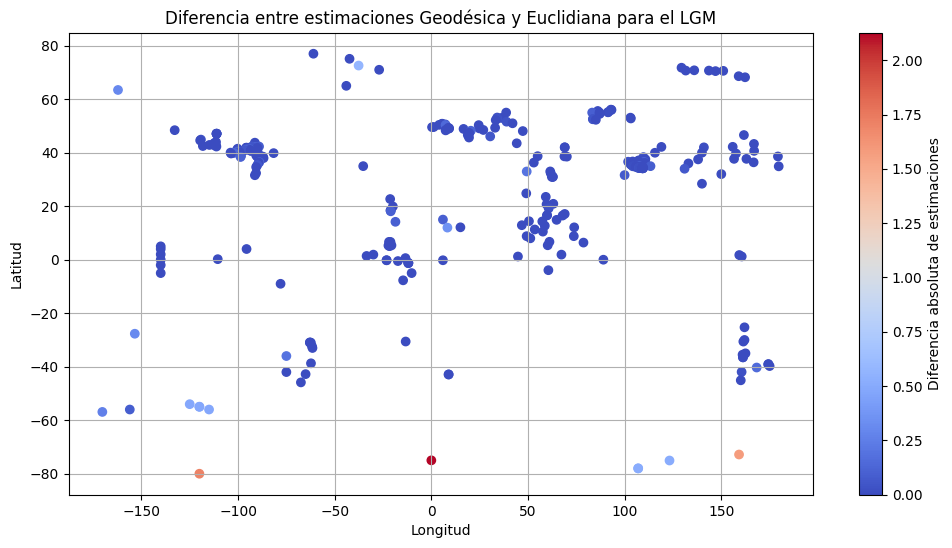

In [9]:
# Cálculo de la diferencia entre las estimaciones geodésica y euclidiana
dataframe_empirical_Holocene['diferencia'] = np.abs(dataframe_empirical_Holocene['est_geodesica'] - dataframe_empirical_Holocene['est_euclidiana'])
dataframe_empirical_LGM['diferencia'] = np.abs(dataframe_empirical_LGM['est_geodesica'] - dataframe_empirical_LGM['est_euclidiana'])

# Visualización de la diferencia para el Holoceno
plt.figure(figsize=(12, 6))
plt.scatter(dataframe_empirical_Holocene['lon'], dataframe_empirical_Holocene['lat'],
            c=dataframe_empirical_Holocene['diferencia'], cmap='coolwarm', marker='o')
plt.colorbar(label='Diferencia absoluta de estimaciones')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Diferencia entre estimaciones Geodésica y Euclidiana para el Holoceno')
plt.grid(True)
plt.show()

# Visualización de la diferencia para el LGM
plt.figure(figsize=(12, 6))
plt.scatter(dataframe_empirical_LGM['lon'], dataframe_empirical_LGM['lat'],
            c=dataframe_empirical_LGM['diferencia'], cmap='coolwarm', marker='o')
plt.colorbar(label='Diferencia absoluta de estimaciones')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Diferencia entre estimaciones Geodésica y Euclidiana para el LGM')
plt.grid(True)
plt.show()


In [10]:
dataframe_empirical_Holocene.head()

,lon,lat,dep,log_dep,log_dep_norm,est_geodesica,est_euclidiana,diferencia
0,1.37,78.87,3.999995,0.602059,0.185196,-1.165017,-0.524846,0.640171
1,-61.00,77.00,0.040000,-1.397941,-1.669137,-1.515357,-1.942044,0.426687
2,-42.32,75.10,0.008000,-2.096911,-2.317199,-1.535884,-1.942044,0.406160
3,-6.72,74.58,3.100001,0.491362,0.082561,-1.165017,-0.524846,0.640171
4,-37.63,72.58,0.009000,-2.045758,-2.269772,-1.471578,-1.812432,0.340854


# **Inciso 6**



### a) 
Las diferencias en las estimaciones entre la distancia geodésica y la euclidiana pueden ser más pronunciadas en ciertas regiones debido a la geometría esférica de la Tierra. En distancias largas o cerca de los polos, la distancia geodésica, que tiene en cuenta la curvatura terrestre, proporcionará una medición más precisa que la distancia euclidiana, que asume una Tierra plana. Por lo tanto, esperaríamos ver mayores discrepancias en áreas donde los puntos están más alejados o en latitudes extremas.

### b) 
En los polos, la distancia geodésica es definitivamente más confiable que la euclidiana debido a la convergencia de los meridianos. Las distancias euclidianas se distorsionan significativamente en estas regiones, ya que no reflejan la verdadera proximidad entre puntos en una esfera. La distancia geodésica, por otro lado, sí mide correctamente las distancias sobre la superficie curva de la Tierra.

### c) 
Alrededor de la longitud 180°, que es opuesta al meridiano primario, la distancia euclidiana puede subestimar significativamente las distancias porque no representa correctamente la línea de cambio de fecha. La distancia geodésica será más confiable en esta región, ya que correctamente mide la distancia más corta entre dos puntos a través de la esfera terrestre.

### d) 
Las diferencias observadas entre los resultados para el Holoceno y el LGM podrían reflejar los distintos estados climáticos y ambientales de la Tierra en cada período. Durante el LGM, por ejemplo, sabemos que había grandes capas de hielo que cubrían muchas regiones del norte, lo que habría afectado la forma en que el polvo fue transportado y depositado. Esto podría haber llevado a una variabilidad más significativa en las estimaciones de deposición de polvo cuando se compara con el Holoceno, que ha tenido un clima más estable y condiciones geográficas más similares a las actuales. Además, las diferencias en las estimaciones de distancia podrían ser exacerbadas por estas condiciones cambiantes, ya que la metodología de muestreo, la distribución de los sitios de muestreo y la densidad de los datos pueden variar considerablemente entre los dos conjuntos de datos.

### e) 
La elección del número de vecinos cercanos, o 'k', es crítica para la precisión de la estimación. Un 'k' pequeño puede ser sensible al ruido y a las variaciones locales, mientras que un 'k' grande puede suavizar demasiado las estimaciones. La elección óptima de 'k' podría basarse en un equilibrio entre la precisión local y la generalización, y podría determinarse a través de la validación cruzada y el análisis de la sensibilidad de las estimaciones a diferentes valores de 'k'.


# **Consideraciones**

- **Uso de código de ejemplo:** Para una mejor comprensión y análisis de los datos, se ha utilizado información proporcionada por el código de ejemplo. Además, se ha definido explícitamente la función de distancia euclidiana en nuestro notebook personal. Esto ha permitido una evaluación más profunda de las diferencias entre las distancias euclidiana y geodésica.

- **Radio terrestre:** Se ha fijado el valor del radio de la Tierra a 6,371 km para el cálculo de la distancia geodésica. Este valor se ha utilizado de manera estándar para garantizar la consistencia en los cálculos a través de todos los análisis.

- **Selección de vecinos cercanos:** La cantidad de vecinos más cercanos se ha fijado en cinco ('5') para la funcionalidad del código. Esta decisión se basa en criterios de optimización y equilibrio entre la precisión local y la capacidad de generalización de los resultados.

- **Inicio del notebook:** El notebook inicia a partir del inciso 2, siguiendo la secuencia de instrucciones específicas para la tarea. 

- **Estimación Euclidiana:** Además de las estimaciones geodésicas, hemos calculado una serie de estimaciones ('est_euclidiana') utilizando la distancia euclidiana. Esto nos permite realizar comparaciones y visualizaciones posteriores para evaluar el impacto de la metodología de distancia en nuestras estimaciones de deposición de polvo.

# **Bibliografía**

- **Código de ejemplo de Canvas:** Utilizado como base para entender los métodos de cálculo de distancia y para implementar el algoritmo de k-vecinos más cercanos.

- **Fórmulas estándar de distancia:** Para la implementación de las funciones de distancia euclidiana y geodésica, utilizando un radio terrestre de 6,371 km como estándar.

- **Documentación de Python y bibliotecas asociadas:** El uso de NumPy y pandas fue esencial para realizar cálculos y manipular datos eficientemente.

- **Matplotlib:** Esta biblioteca de visualización de datos proporcionó las herramientas necesarias para crear mapas de calor y gráficos comparativos de las estimaciones de deposición de polvo.

- **ChatGPT de OpenAI:** Utilizado para estructurar y ordenar el código, así como para proporcionar explicaciones detalladas y generar Markdown para la documentación del Jupyter Notebook.
